In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

# Plant Pathology 2020 - FGVC7

In [2]:
MODEL_NAME = 'efficientnet-b1'

BATCH_SIZE = 1
INPUT_SIZE = EfficientNet.get_image_size(MODEL_NAME)
EPOCH_TIME = 30

DEVICE = torch.device('cuda')

## Data Loading

The code above shows how I load the data sets. 80% of the training set will be used for training, and the other 20% will be used for validation.

Besides, I use these methods to augment training sets:

* RandomGreyscale
* RandomHorizontalFlip
* RandomVerticalFlip
* RandomRotation
* RandomPerspective


In [3]:
from torch.utils.data import Dataset, random_split
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomGrayscale, RandomPerspective, RandomRotation
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from PIL import Image


class PlantDataset(Dataset):
    
    def __init__(self, train = True):
        
        self.train = train
        
        self.dataset = pd.read_csv('./dataset/{}.csv'.format('train' if train else 'test'))
        
        if self.train:
            
            self.augment = Compose([
                RandomGrayscale(),
                RandomHorizontalFlip(),
                RandomVerticalFlip(),
                RandomRotation((-180, +180)),
                RandomPerspective(),
            ])
            
        self.transform = Compose([
            Resize((INPUT_SIZE, INPUT_SIZE)),
            ToTensor(),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        
    def __len__(self):
        
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        
        image = Image.open('./dataset/images/{}.jpg'.format(self.dataset.loc[index, 'image_id']))
        
        if self.train:
            image = self.augment(image)
        
        image = self.transform(image)
        
        if self.train:
            
            label = np.argmax(self.dataset.loc[index, ['healthy', 'multiple_diseases', 'rust', 'scab']].values)
            
            return image, label
        else:
            return image, index

## Model Validation

In [4]:
def validate(model, loader, pbar = None):

    if pbar is None:
        with tqdm(total = len(loader) * BATCH_SIZE) as pbar:
            return validate(model, loader, pbar)
        
    correct, total = 0, 0
            
    with torch.no_grad():
        for images, labels in loader:

            outputs = model(images.to(DEVICE).float())

            _, predictions = torch.max(outputs.data, 1)

            predictions = predictions.cpu().numpy()

            for idx, prediction in enumerate(predictions):

                if prediction == labels[idx]:
                    correct = correct + 1

                total = total + 1

            pbar.update(BATCH_SIZE)
                
    return correct / total

## Model Training

In [5]:
import os
import json
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


def train(model, train_set, test_set, label = None, ax = None, again = False):

    if (label is not None) and os.path.isfile('./checkpoints/{}.ckpt'.format(label)):
        model.load_state_dict(torch.load('./checkpoints/{}.ckpt'.format(label)))
    
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters())
    
    scores, losses = [], []
    
    if (label is not None) and os.path.isfile('./checkpoints/{}.scores.json'.format(label)):
        with open('./checkpoints/{}.scores.json'.format(label), 'r') as file:
            scores = json.load(file)
            
    if (label is not None) and os.path.isfile('./checkpoints/{}.losses.json'.format(label)):
        with open('./checkpoints/{}.losses.json'.format(label), 'r') as file:
            losses = json.load(file)
    
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
    test_loader = DataLoader(test_set, batch_size = BATCH_SIZE)
    
    if again or (len(scores) == 0 and len(scores) == 0):
    
        with tqdm(total = EPOCH_TIME * (len(train_loader) + len(test_loader)) * BATCH_SIZE) as pbar:
            for epoch in range(0, EPOCH_TIME):

                for idx, (images, labels) in enumerate(train_loader):

                    outputs = model(images.to(DEVICE).float())
                    loss = criterion(outputs, labels.to(DEVICE))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pbar.update(BATCH_SIZE)

                loss = loss.cpu().item()
                score = validate(model, test_loader, pbar)

                pbar.set_postfix(loss = loss, score = score)

                losses.append(loss)
                scores.append(score)
    
    if label is not None:
        
        torch.save(model.state_dict(),'./checkpoints/{}.ckpt'.format(label))

        with open('./checkpoints/{}.scores.json'.format(label), 'w') as file:
            json.dump(scores, file)
            
        with open('./checkpoints/{}.losses.json'.format(label), 'w') as file:
            json.dump(losses, file)
        
    if ax is not None:
        
        ax.plot(scores, label = 'score')
        ax.plot(losses, label = 'loss')

        ax.legend()

## Prediction

In [9]:
from torch.utils.data import DataLoader


def predict(model, dataset, pbar = None):

    if pbar is None:
        with tqdm(total = len(dataset)) as pbar:
            return predict(model, dataset, pbar)
        
    submission = pd.DataFrame(np.nan, index = np.arange(0, len(dataset)), columns = ['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'])
    
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size = BATCH_SIZE):

            outputs = model(images.to(DEVICE).float()).data.cpu().numpy()
            
            for idx, prediction in enumerate(outputs):
                
                submission.loc[labels[idx].item(), ['healthy', 'multiple_diseases', 'rust', 'scab']] = prediction

            pbar.update(len(labels))
    
    for idx in range(0, len(dataset)):
        submission.loc[idx, 'image_id'] = 'Test_{}'.format(idx)
                    
    return submission

## Efficient-Net Model

  0%|          | 0/1821 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b1


100%|██████████| 1821/1821 [02:06<00:00, 14.34it/s]


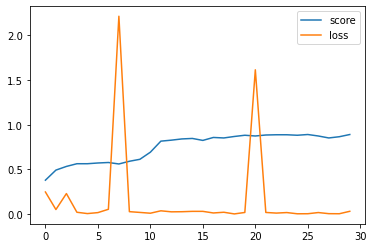

In [11]:
from torch.utils.data import DataLoader

efficient_net = EfficientNet.from_pretrained(MODEL_NAME, num_classes = 4).to(DEVICE)

train_raw = PlantDataset(train = True)

train_set, test_set = random_split(train_raw, [int(0.8 * len(train_raw)), len(train_raw) - int(0.8 * len(train_raw))])

train(efficient_net, train_set, test_set, label = MODEL_NAME, ax = plt.subplot())

submission = predict(efficient_net, PlantDataset(train = False))

submission.to_csv('./dataset/submission_efficient_net_b1.csv', index = False)